In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

EXP_NAME = "autoencoder-paraphrase"
PROJECT_ROOT = "/home/jovyan/vmeshchaninov/HierarchicalDiffusion"
EXP_RESULT_PATH = f"{PROJECT_ROOT}/experiments/results/{EXP_NAME}/"
os.makedirs(EXP_RESULT_PATH, exist_ok=True)
sys.path.append(PROJECT_ROOT)
os.environ["PROJECT_ROOT"] = PROJECT_ROOT

In [3]:
import torch
import hydra
from omegaconf import DictConfig, OmegaConf
from hydra.core.global_hydra import GlobalHydra

from encoder_trainer import EncoderTrainer

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import rel_entr  # KL divergence computation

/home/jovyan/.mlspace/envs/dif_env_v2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reset Hydra to avoid conflicts if already initialized
GlobalHydra.instance().clear()

# Initialize Hydra and load config manually
hydra.initialize(config_path="../conf", version_base=None)  # Set path to your configs

# Load the configuration
cfg = hydra.compose(config_name="config")  # Replace with your main config file

# Print the loaded config
print(OmegaConf.to_yaml(cfg))

autoencoder:
  model:
    checkpoints_prefix: autoencoder
    text_encoder: bert-base-cased
    text_encoder_freeze_params: true
    num_workers: 30
    load_checkpoint: null
  latent:
    dim: 768
    resolutions:
    - 1
    - 1
    - 2
    - 4
    - 8
    - 16
    is_detach_previous_latents: true
  hidden:
    size: 768
  loss:
    level_weights:
    - 1.0
    - 1.0
    - 1.0
    - 1.0
    - 1.0
    - 1.0
  training:
    training_iters: 20000
    batch_size: 256
    batch_size_per_gpu: 256
  params:
    text_encoder: 0
    encoder: 0
    decoder: 0
    total: 0
  all_params: dict()
  logging:
    log_freq: 10
    eval_freq: 5000
  optimizer:
    name: stableadam
    learning_rate: 0.0002
    warmup_lr: 1.0e-08
    min_lr: 0.0001
    weight_decay: 1.0e-05
    eps: 1.0e-06
    betas:
    - 0.9
    - 0.98
    linear_warmup: 10
    grad_clip_norm: 10.0
encoder:
  attention:
    head_size: 64
    num_heads: 12
    probs_dropout: 0.0
    qk_norm: true
    implementation: flash_attention_2

/home/jovyan/.mlspace/envs/dif_env_v2/lib/python3.11/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [32]:
# Setup the config
cfg.ddp.enabled = False
cfg.autoencoder.latent.resolutions=[16]
cfg.autoencoder.model.load_checkpoint = "./autoencoder-latent_resolutions=[16]-mlm_probabilities_dec=[1.0]-wikipedia-v3.1/50000.pth"


In [33]:
trainer = EncoderTrainer(cfg)

Checkpotint ./autoencoder-latent_resolutions=[16]-mlm_probabilities_dec=[1.0]-wikipedia-v3.1/50000.pth loaded
Checkpotint ./autoencoder-latent_resolutions=[16]-mlm_probabilities_dec=[1.0]-wikipedia-v3.1/50000.pth loaded


In [34]:
from datasets import load_from_disk

data = load_from_disk("/home/jovyan/vmeshchaninov/HierarchicalDiffusion/data/rocstories")

In [35]:
data

DatasetDict({
    train: Dataset({
        features: ['text_trg'],
        num_rows: 88161
    })
    test: Dataset({
        features: ['text_trg'],
        num_rows: 10000
    })
})

In [36]:
from transformers import AutoTokenizer
from encoder_trainer import cross_entropy_loss, accuracy

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [37]:
batch = tokenizer(
    data["test"]['text_trg'],
    add_special_tokens=True,
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt",
    return_special_tokens_mask=True,
    return_token_type_ids=False,
).to("cuda:0")

In [38]:
with torch.no_grad(), torch.autocast(device_type='cuda', dtype=torch.bfloat16):
    encoder_latents = trainer.encoder(
        token_ids=batch["input_ids"],
        mask_tokens=batch["attention_mask"]
    )

/home/jovyan/.mlspace/envs/dif_env_v2/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


In [39]:
acc_list = []

for i in range(0, 10000, 1000):
    with torch.no_grad(), torch.autocast(device_type='cuda', dtype=torch.bfloat16):
        latents = encoder_latents[i: i+1000]
        logits = trainer.decoder(encoder_latents=latents)
        acc = accuracy(
            logits=logits,
            target=batch["input_ids"][i: i+1000],
            mask=batch["attention_mask"][i: i+1000]
        )

        acc_list.append(acc.item())


In [40]:
np.mean(acc_list)

0.9993908047676087

In [33]:
ind = 0

with torch.no_grad(), torch.autocast(device_type='cuda', dtype=torch.bfloat16):
    latents = encoder_latents[ind: ind+1]
    logits = trainer.decoder(encoder_latents=latents)
    acc = accuracy(
        logits=logits,
        target=batch["input_ids"][ind: ind+1],
        mask=batch["attention_mask"][ind: ind+1]
    )
print(acc.item())

0.6976743936538696


/home/jovyan/.mlspace/envs/dif_env_v2/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


In [34]:
tokenizer.batch_decode(batch["input_ids"][ind: ind+1])

['[CLS] Jill wanted to lose weight. She started walking to work. She also brought her own healthy lunch. She lost 20 pounds in three months. Now she heads a weight loss club to motivate others! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]']

In [35]:
tokenizer.batch_decode(logits.argmax(dim=-1))

['[CLS] Jill wanted to lose weight. She started walking to work. She also brought her own healthy lunch. She brought 20ly in three months. brought she brought a weight healthy lunch. 20sp lost her ’ in months three months in no own lunch. [SEP] years lost. gained every 20 months months [SEP] Long. [SEP] a [SEP] [SEP] club to motivate others, [SEP]ly now now now now [SEP] a the. loss club to mivate [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] Now [SEP] [SEP] s family [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]! [SEP]']

In [17]:

wiki_data = load_from_disk("/home/jovyan/vmeshchaninov/DiffusionLanguageModel/data/wikipedia-emnlp")

In [19]:
batch = tokenizer(wiki_data["test"]['target'])
lengths = [len(t) for t in batch["input_ids"]]

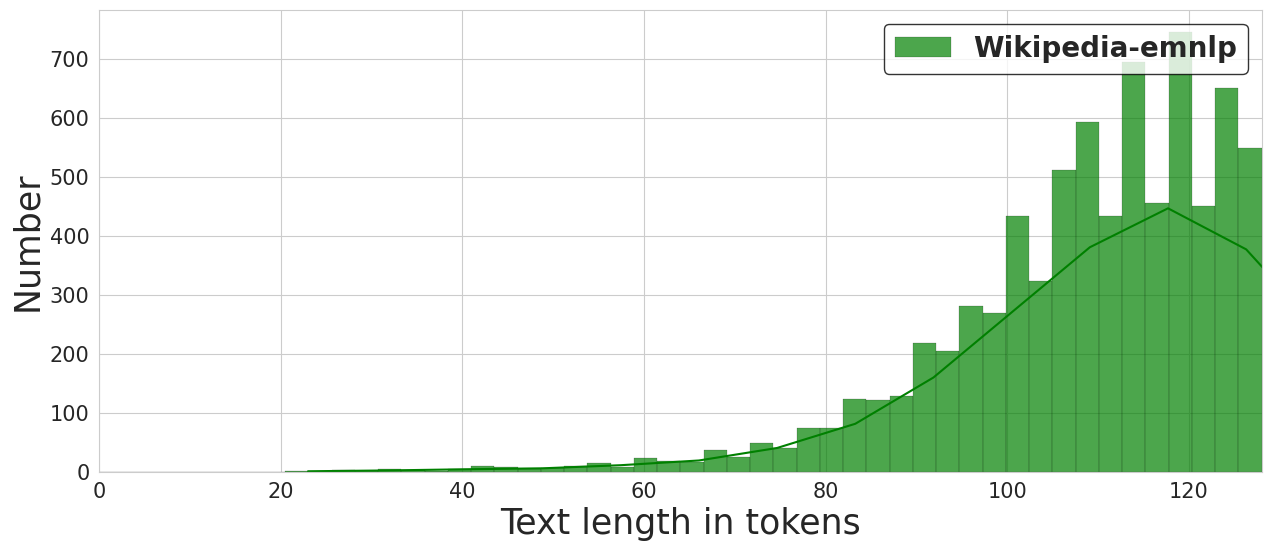

In [21]:
# Set the style for an awesome look
sns.set_style("whitegrid")
plt.figure(figsize=(15, 6))

font_size = 20
num_bins = 50
bins = np.linspace(0, 128, num_bins + 1)

# Plot histograms
sns.histplot(lengths, bins=bins, kde=True, color="green", label="Wikipedia-emnlp", alpha=0.7, edgecolor="black")

# Add title and labels with a creative touch
# Title with colored text
# plt.title("Positivity vs Negativity: A Histogram of Contrasts", fontsize=font_size + 10, fontweight="bold", pad=15)

plt.xlabel("Text length in tokens", fontsize=font_size + 5)
plt.ylabel("Number", fontsize=font_size + 5)

# Set x-axis limits between 0 and 1000
plt.xlim(0, 128)

# Adjust tick sizes
plt.xticks(fontsize=font_size - 5)
plt.yticks(fontsize=font_size - 5)

# Add legend
legend = plt.legend(frameon=True, loc="upper right", prop={'weight': 'bold', 'size': font_size}, edgecolor="black")  # Positioned at the upper right with bold text

# Get legend position
legend_bbox = legend.get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted())

# Save as PDF
# plt.savefig(f"{PROJECT_ROOT}/experiments/results/{EXP_NAME}/histogram.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()